# Satellite Images of Hurricane Damage

Contributors: Abhinav Agarwal

**Overview**

The data used in this notebook are satellite images from the Greater Houston area after Hurricane Harvey in 2017. Each image has been labelled as either "Flooded/Damaged" or "Undamaged".

The data is available for download [here](https://www.kaggle.com/kmader/satellite-images-of-hurricane-damage), and the study associated with the dataset is available [here](https://arxiv.org/abs/1807.01688).

**Motivation**

As stated in the abstract of the associated study:

> After a hurricane, damage assessment is critical to emergency managers for efficient response and resource allocation. One way to gauge the damage extent is to quantify the number of flooded/damaged buildings, which is traditionally done by ground survey. This process can be labor-intensive and time-consuming.

One way to improve the efficiency of building damage assessment is to identify flooded/damaged buildings from satellite remote sensing data alone.

**Method**

In this notebook, I train a convolutional neural network to identify flooded/damaged buildings.

In particular, I use transfer learning with fine-tuning to achieve high accuracy while minimizing the amount of compute required to train the classifier.

Note that the notebook was executed using a Kaggle GPU kernel, so if you are viewing this notebook on GitHub, the images themselves have not been downloaded into the GitHub repository. However, you can still execute this notebook by either downloading the data using the links above, or forking this notebook on Kaggle [here](https://www.kaggle.com/yuempark/satellite-images-of-hurricane-damage).

Also, as this was my first experience using TensorFlow and Keras, I found the following websites to be particularly helpful in getting the model up and running:

* https://www.tensorflow.org/tutorials/load_data/images
* https://www.tensorflow.org/tutorials/images/transfer_learning
* https://www.tensorflow.org/guide/data

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The input directory structure:

In [2]:
!ls -lha ../input/satellite-images-of-hurricane-damage

total 4.0K
drwxr-xr-x 6 nobody nogroup    0 May  7 09:12 .
drwxr-xr-x 3 root   root    4.0K May  7 14:39 ..
drwxr-xr-x 4 nobody nogroup    0 May  7 09:10 test
drwxr-xr-x 4 nobody nogroup    0 May  7 09:11 test_another
drwxr-xr-x 4 nobody nogroup    0 May  7 09:11 train_another
drwxr-xr-x 4 nobody nogroup    0 May  7 09:12 validation_another


File sizes:

In [3]:
input_path = '../input/satellite-images-of-hurricane-damage/'

def print_file_sizes(input_path, subset):
    print('{}:'.format(subset))
    print('')
    path = input_path + subset + '/'
    for f in os.listdir(path):
        if not os.path.isdir(path + f):
            print(f.ljust(30) + str(round(os.path.getsize(path + f) / 1000000, 2)) + 'MB')
        else:
            sizes = [os.path.getsize(path+f+'/'+x)/1000000 for x in os.listdir(path + f)]
            print(f.ljust(30) + str(round(sum(sizes), 2)) + 'MB' + ' ({} files)'.format(len(sizes)))
    print('')
    
print_file_sizes(input_path, 'train_another')
print_file_sizes(input_path, 'validation_another')
print_file_sizes(input_path, 'test_another')
print_file_sizes(input_path, 'test')

train_another:

damage                        12.56MB (5000 files)
no_damage                     15.07MB (5000 files)

validation_another:

damage                        2.52MB (1000 files)
no_damage                     3.02MB (1000 files)

test_another:

damage                        20.12MB (8000 files)
no_damage                     3.01MB (1000 files)

test:

damage                        2.53MB (1000 files)
no_damage                     2.99MB (1000 files)



# Training Labels

All labels for the images are encoded into the directory structure of this dataset. Just extract it into a pandas DataFrame:

In [4]:
image_df = pd.DataFrame({'path': list(Path(input_path).glob('**/*.jp*g'))})

image_df['damage'] = image_df['path'].map(lambda x: x.parent.stem)
image_df['data_split'] = image_df['path'].map(lambda x: x.parent.parent.stem)
image_df['location'] = image_df['path'].map(lambda x: x.stem)
image_df['lon'] = image_df['location'].map(lambda x: float(x.split('_')[0]))
image_df['lat'] = image_df['location'].map(lambda x: float(x.split('_')[-1]))
image_df['path'] = image_df['path'].map(lambda x: str(x)) # convert the path back to a string

image_df.head()

,path,damage,data_split,location,lon,lat
0,../input/satellite-images-of-hurricane-damage/...,damage,train_another,-95.656807_29.835212,-95.656807,29.835212
1,../input/satellite-images-of-hurricane-damage/...,damage,train_another,-95.630673_29.775671999999997,-95.630673,29.775672
2,../input/satellite-images-of-hurricane-damage/...,damage,train_another,-95.639432_29.844975,-95.639432,29.844975
3,../input/satellite-images-of-hurricane-damage/...,damage,train_another,-95.586533_29.757163000000002,-95.586533,29.757163
4,../input/satellite-images-of-hurricane-damage/...,damage,train_another,-95.270494_29.60561,-95.270494,29.605610


Make a quick plot of the spatial distribution of the images:

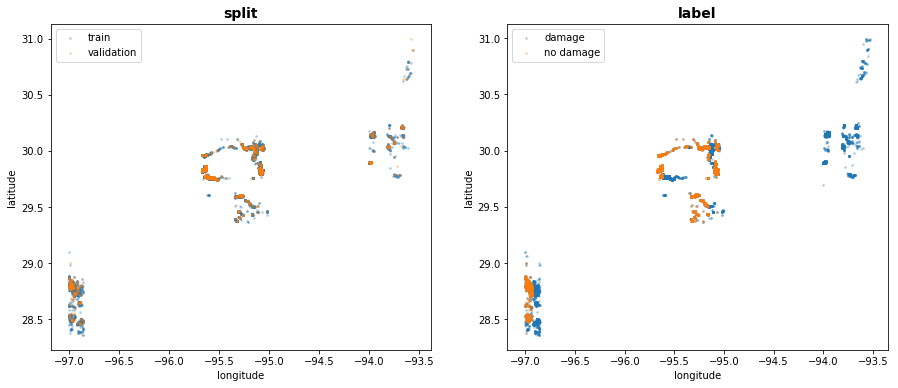

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

s = 3
alpha = 0.25

# get the train-validation-test splits
image_df_train = image_df[image_df['data_split']=='train_another'].copy()
image_df_val = image_df[image_df['data_split']=='validation_another'].copy()
image_df_test = image_df[image_df['data_split']=='test_another'].copy()

# sort to ensure reproducible behaviour
image_df_train.sort_values('lat', inplace=True)
image_df_val.sort_values('lat', inplace=True)
image_df_test.sort_values('lat', inplace=True)
image_df_train.reset_index(drop=True,inplace=True)
image_df_val.reset_index(drop=True,inplace=True)
image_df_test.reset_index(drop=True,inplace=True)

ax[0].scatter(image_df_train['lon'], image_df_train['lat'], color='C0', s=s, alpha=alpha, label='train')
ax[0].scatter(image_df_val['lon'], image_df_val['lat'], color='C1', s=s, alpha=alpha, label='validation')

ax[0].set_title('split', fontsize=14, fontweight='bold')
ax[0].legend()
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('latitude')

image_df_dmg = image_df[image_df['damage']=='damage'].copy()
image_df_nodmg = image_df[image_df['damage']=='no_damage'].copy()

image_df_dmg.reset_index(drop=True,inplace=True)
image_df_nodmg.reset_index(drop=True,inplace=True)

ax[1].scatter(image_df_dmg['lon'], image_df_dmg['lat'], color='C0', s=s, alpha=alpha, label='damage')
ax[1].scatter(image_df_nodmg['lon'], image_df_nodmg['lat'], color='C1', s=s, alpha=alpha, label='no damage')

ax[1].set_title('label', fontsize=14, fontweight='bold')
ax[1].legend()
ax[1].set_xlabel('longitude')
ax[1].set_ylabel('latitude')

plt.show(fig)

Zoom in on a specific geographic location to see more detail:

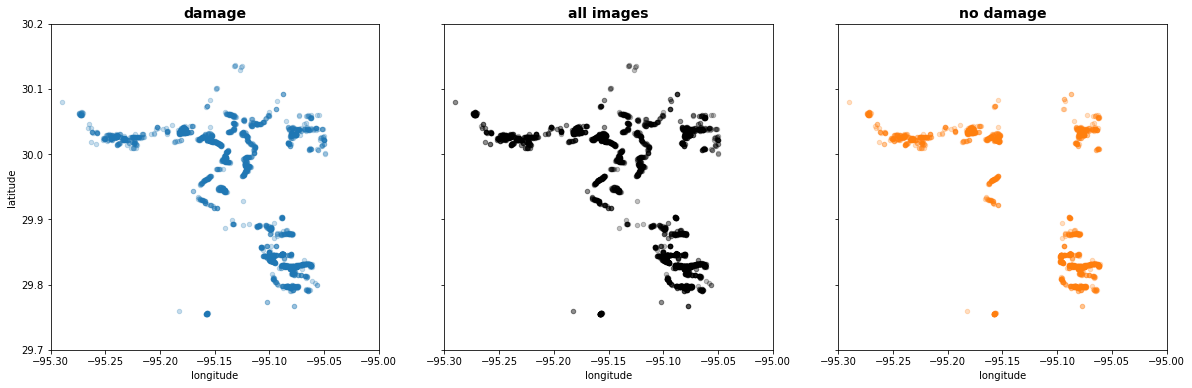

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,6), sharex=True, sharey=True)

s = 20
alpha = 0.25

ax[0].scatter(image_df_dmg['lon'], image_df_dmg['lat'], color='C0', s=s, alpha=alpha, label='damage')
ax[0].set_title('damage', fontsize=14, fontweight='bold')

ax[1].scatter(image_df_dmg['lon'], image_df_dmg['lat'], color='k', s=s, alpha=alpha, label='damage')
ax[1].scatter(image_df_nodmg['lon'], image_df_nodmg['lat'], color='k', s=s, alpha=alpha, label='no damage')
ax[1].set_title('all images', fontsize=14, fontweight='bold')

ax[2].scatter(image_df_nodmg['lon'], image_df_nodmg['lat'], color='C1', s=s, alpha=alpha, label='no damage')
ax[2].set_title('no damage', fontsize=14, fontweight='bold')

ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[2].set_xlabel('longitude')

ax[0].set_xlim(-95.3,-95)
ax[0].set_ylim(29.7,30.2)

plt.show(fig)

# Training Images

First, inspect the images:

In [7]:
import cv2

# read it in unchanged, to make sure we aren't losing any information
img = cv2.imread(image_df['path'][0], cv2.IMREAD_UNCHANGED)
np.shape(img)

(128, 128, 3)

In [8]:
type(img[0,0,0])

numpy.uint8

In [9]:
np.min(img[:,:,:])

0

In [10]:
np.max(img[:,:,:])

255

Let's plot a few (note that OpenCV reads the image in as BGR):

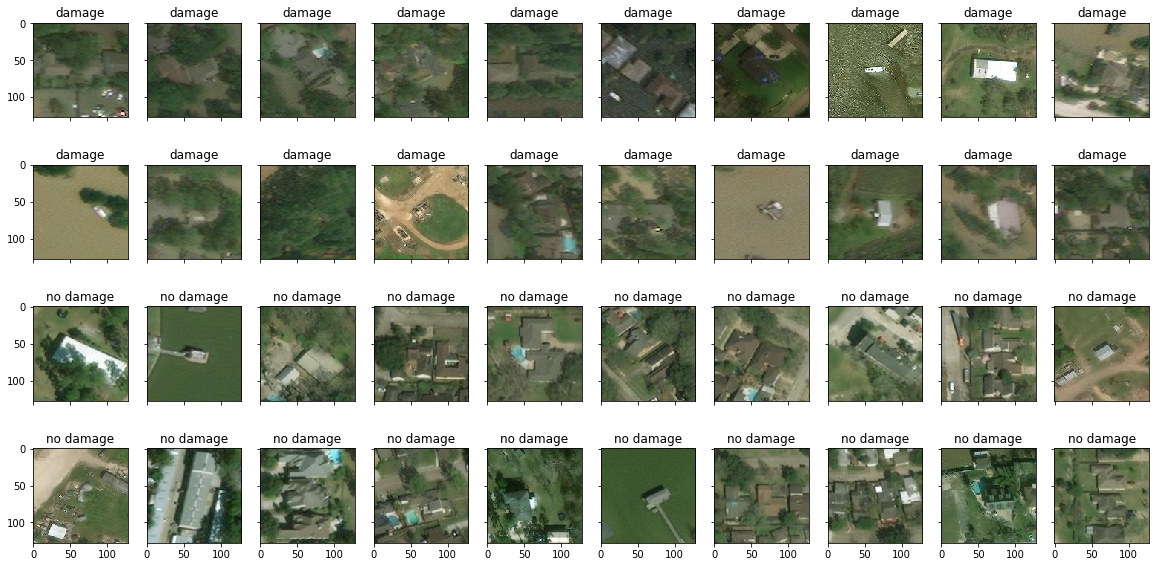

In [11]:
fig, ax = plt.subplots(nrows=4, ncols=10, sharex=True, sharey=True, figsize=(20,10))

ax = ax.flatten()

for i in range(20):
    img = cv2.imread(image_df_dmg['path'][i], cv2.IMREAD_UNCHANGED)
    ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i].set_title('damage')
    
for i in range(20,40):
    img = cv2.imread(image_df_nodmg['path'][i], cv2.IMREAD_UNCHANGED)
    ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i].set_title('no damage')
    
plt.show()

Zoom in on a few images:

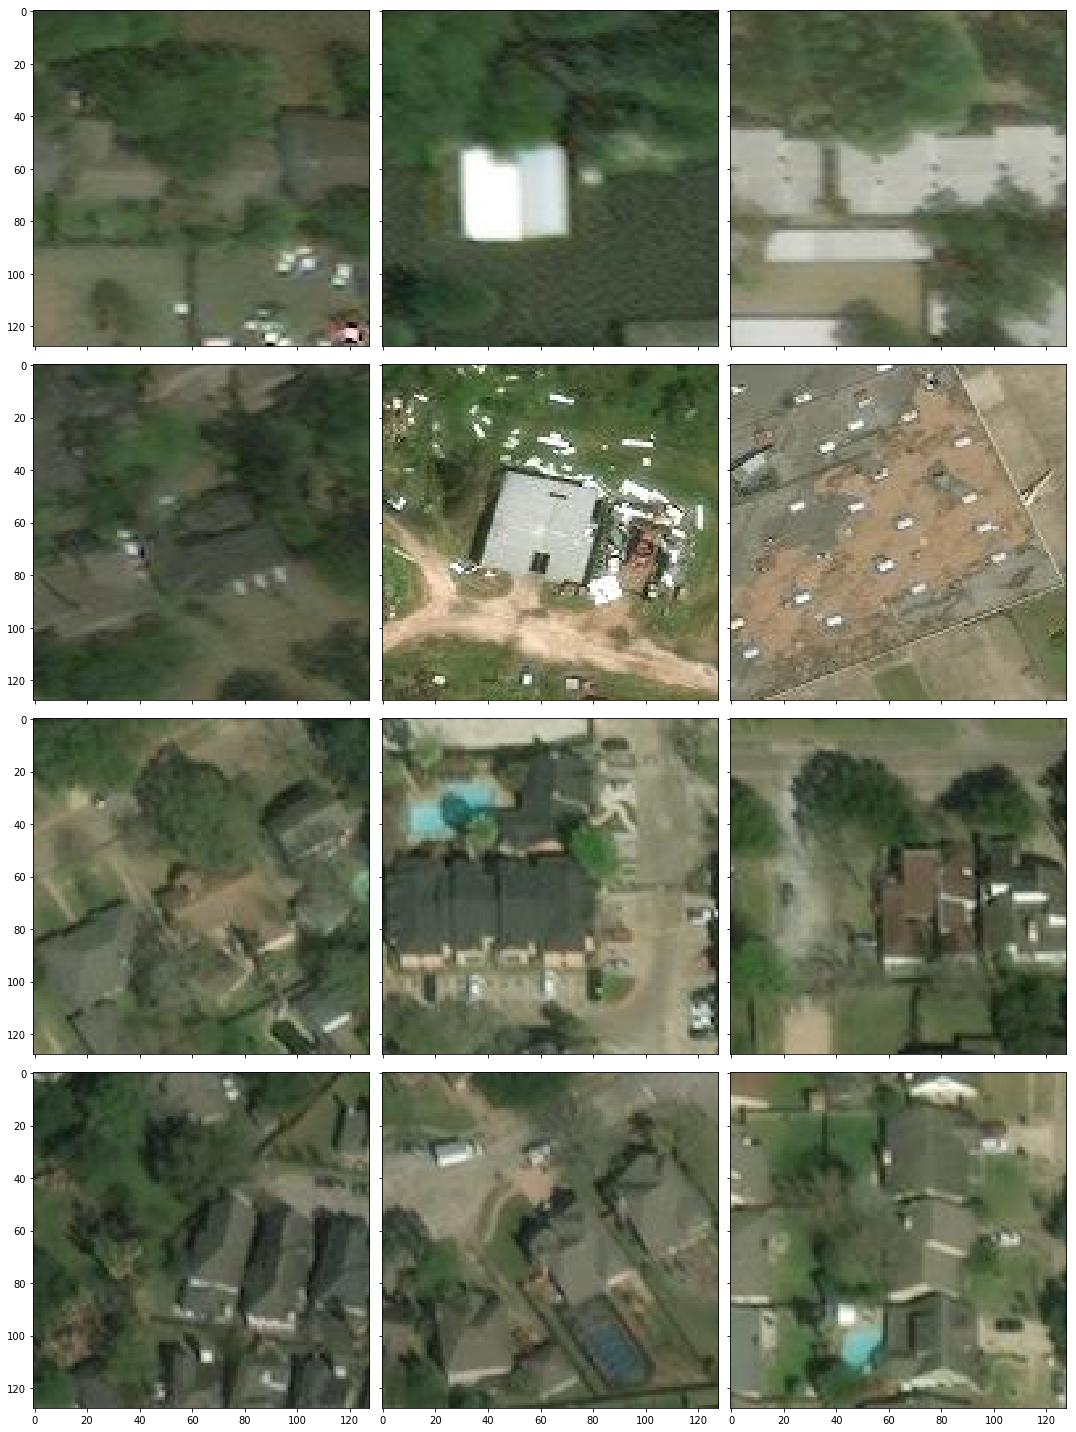

In [12]:
fig, ax = plt.subplots(nrows=4, ncols=3, sharex=True, sharey=True, figsize=(15,20))

ax = ax.flatten()

selected_dmg = np.array([0,1,2,3,4,5])*100
selected_nodmg = np.array([0,1,2,3,4,5])*99

for i in range(6):
    img = cv2.imread(image_df_dmg['path'][selected_dmg[i]], cv2.IMREAD_UNCHANGED)
    ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    #ax[i].set_title('damage')
    
for i in range(6):
    img = cv2.imread(image_df_nodmg['path'][selected_nodmg[i]], cv2.IMREAD_UNCHANGED)
    ax[i+6].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    #ax[i+6].set_title('no damage')
    
fig.tight_layout()
plt.show()

A histogram of values:

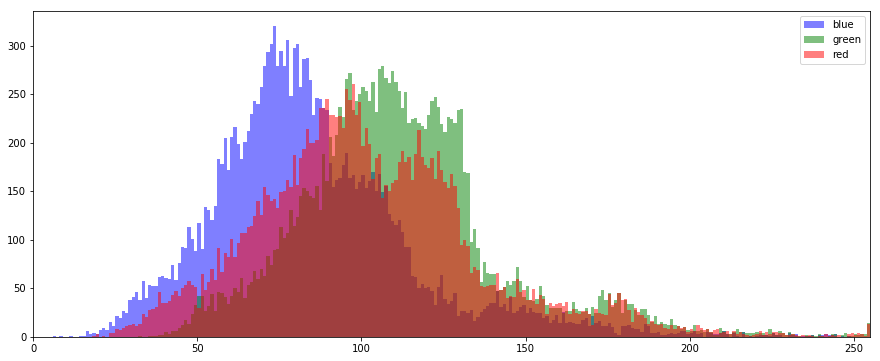

In [13]:
jpg_channels = ['blue','green','red']
jpg_channel_colors = ['b','g','r']

fig, ax = plt.subplots(figsize=(15,6))

for i in range(len(jpg_channels)):
    ax.hist(img[:,:,i].flatten(), bins=np.arange(256),
            label=jpg_channels[i], color=jpg_channel_colors[i], alpha=0.5)
    ax.legend()
    
ax.set_xlim(0,255)
    
plt.show(fig)

# Transfer Learning

In general, there are two types of transfer learning in the context of deep learning:

* via feature extraction
    * treating the network as an arbitrary feature extractor
    * essentially 'chop off' the network at our pre-specified layer (typically prior to the fully-connected layers when actual classification predictions are made), then propagate some input through this 'shortened' network, get the output array, flatten it, and use that as the feature vector for the original input in another classification algorithm
    * the two most common machine learning models for transfer learning via feature extraction are logistic regression and linear SVM:
        * CNN's are non-linear models capable of learning non-linear features — we are assuming that the features learned by the CNN are already robust and discriminative
        * feature vectors tend to be very large and have high dimensionality - we therefore need a fast model that can be trained on top of the features
        * linear models tend to be very fast to train
* via fine-tuning
    * removing the fully-connected layers of an existing network, placing a new set of fully-connected layers on top of the network, and then fine-tuning these weights (and optionally previous layers) to recognize the new object classes
    * this technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on

In this notebook, I will use the fine-tuning method, but an example of using the feature extraction method can be found [here](https://www.kaggle.com/kmader/damage-classification-with-resnet-features).

In [14]:
import tensorflow as tf
tf.__version__

'2.1.0-rc0'

# Image Preprocessing

We could use `tf.keras.preprocessing` to load the images, but it has 3 downsides:

1. it's slow
2. it lacks fine-grained control
3. it's not well integrated with the rest of TensorFlow

Alternatively, we could use `tf.data.Dataset`. From the documentation:

> The `tf.data` API enables you to build complex input pipelines from simple, reusable pieces. For example, the pipeline for an image model might aggregate data from files in a distributed file system, apply random perturbations to each image, and merge randomly selected images into a batch for training.

This API allows the user to only call the data (and apply transformations, etc.) when the data is actually needed, instead of keeping all the images in RAM indefinitely.

I'll use the `tf.data.Dataset` API.

Get the paths and labels:

In [15]:
# paths
train_path = image_df_train['path'].copy().values
val_path = image_df_val['path'].copy().values
test_path = image_df_test['path'].copy().values

# labels
train_labels = np.zeros(len(image_df_train), dtype=np.int8)
train_labels[image_df_train['damage'].values=='damage'] = 1

val_labels = np.zeros(len(image_df_val), dtype=np.int8)
val_labels[image_df_val['damage'].values=='damage'] = 1

test_labels = np.zeros(len(image_df_test), dtype=np.int8)
test_labels[image_df_test['damage'].values=='damage'] = 1

Merge into a Dataset:

In [16]:
train_ds = tf.data.Dataset.from_tensor_slices((train_path, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_path, val_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_path, test_labels))

# note that the `numpy()` function is required to grab the actual values from the Dataset
for path, label in train_ds.take(5):
    print("path  : ", path.numpy().decode('utf-8'))
    print("label : ", label.numpy())

path  :  ../input/satellite-images-of-hurricane-damage/train_another/damage/-96.860867_28.363774.jpeg
label :  1
path  :  ../input/satellite-images-of-hurricane-damage/train_another/damage/-96.861175_28.36379.jpeg
label :  1
path  :  ../input/satellite-images-of-hurricane-damage/train_another/damage/-96.90485699999999_28.375248.jpeg
label :  1
path  :  ../input/satellite-images-of-hurricane-damage/train_another/damage/-96.905101_28.375287.jpeg
label :  1
path  :  ../input/satellite-images-of-hurricane-damage/train_another/damage/-96.90476600000001_28.375337.jpeg
label :  1


Define functions to get the actual images from the paths and do simple transformations. Then map these onto the Dataset:

Note that this is where the most issues were experienced. The code here, which seems simple enough, will fail with an opaque error message even if the slightest thing is done incorrectly. Take note of the comments carefully...

In [17]:
# this function wraps `cv2.imread` - we treat it as a 'standalone' function, and therefore can use
# eager execution (i.e. the use of `numpy()`) to get a string of the path.
# note that no tensorflow functions are used here
def cv2_imread(path, label):
    # read in the image, getting the string of the path via eager execution
    img = cv2.imread(path.numpy().decode('utf-8'), cv2.IMREAD_UNCHANGED)
    # change from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img, label

# this function assumes that the image has been read in, and does some transformations on it
# note that only tensorflow functions are used here
def tf_cleanup(img, label):
    # convert to Tensor
    img = tf.convert_to_tensor(img)
    # unclear why, but the jpeg is read in as uint16 - convert to uint8
    img = tf.dtypes.cast(img, tf.uint8)
    # set the shape of the Tensor
    img.set_shape((128, 128, 3))
    # convert to float32, scaling from uint8 (0-255) to float32 (0-1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image
    img = tf.image.resize(img, [128, 128])
    # convert the labels into a Tensor and set the shape
    label = tf.convert_to_tensor(label)
    label.set_shape(())
    return img, label

AUTOTUNE = tf.data.experimental.AUTOTUNE

# map the cv2 wrapper function using `tf.py_function`
train_ds = train_ds.map(lambda path, label: tuple(tf.py_function(cv2_imread, [path, label], [tf.uint16, label.dtype])),
                        num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda path, label: tuple(tf.py_function(cv2_imread, [path, label], [tf.uint16, label.dtype])),
                    num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(lambda path, label: tuple(tf.py_function(cv2_imread, [path, label], [tf.uint16, label.dtype])),
                      num_parallel_calls=AUTOTUNE)

# map the TensorFlow transformation function - no need to wrap
train_ds = train_ds.map(tf_cleanup, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(tf_cleanup, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(tf_cleanup, num_parallel_calls=AUTOTUNE)

Image augmentation:

Augment the training and validation data by applying random flips and rotations.

In [18]:
def rotate_augmentation(img, label):
    # rotate 0, 90, 180, or 270 degrees with 25% probability for each
    img = tf.image.rot90(img, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32, seed=1111))
    return img, label

def flip_augmentation(img, label):
    # flip with 50% probability for left-right and up-down
    img = tf.image.random_flip_left_right(img, seed=2222)
    img = tf.image.random_flip_up_down(img, seed=3333)
    return img, label

# map the augmentations, creating a new Dataset
augmented_train_ds = train_ds.map(rotate_augmentation, num_parallel_calls=AUTOTUNE)
augmented_train_ds = augmented_train_ds.map(flip_augmentation, num_parallel_calls=AUTOTUNE)

augmented_val_ds = val_ds.map(rotate_augmentation, num_parallel_calls=AUTOTUNE)
augmented_val_ds = augmented_val_ds.map(flip_augmentation, num_parallel_calls=AUTOTUNE)

# concatenate the augmented and original datasets
train_ds = train_ds.concatenate(augmented_train_ds)
val_ds = val_ds.concatenate(augmented_val_ds)

Shuffle:

Note that the buffer size for shuffling defines how random the Dataset becomes - a buffer size that's equal to the number of instances will result in a uniform shuffling over the entire Dataset, and a buffer size equal to 1 will result in no shuffling. Since the data is currently ordered by label, we need make sure we do a nice full shuffle over the entire dataset:

In [19]:
# double the number of samples in the training and validation splits, due to our augmentation procedure
n_train = len(train_labels)*2
n_val = len(val_labels)*2
n_test = len(test_labels)

# shuffle over the entire dataset, seeding the shuffling for reproducible results
train_ds = train_ds.shuffle(n_train, seed=208, reshuffle_each_iteration=True)
val_ds = val_ds.shuffle(n_val, seed=208, reshuffle_each_iteration=True)
test_ds = test_ds.shuffle(n_test, seed=208, reshuffle_each_iteration=True)

Check to make sure everything was read in correctly:

In [20]:
n_train_check = 0
for element in train_ds:
    n_train_check = n_train_check + 1
print(n_train_check)

20000


In [21]:
n_val_check = 0
for element in val_ds:
    n_val_check = n_val_check + 1
print(n_val_check)

4000


In [22]:
n_test_check = 0
for element in test_ds:
    n_test_check = n_test_check + 1
print(n_test_check)

9000


In [23]:
# check that the image was read in correctly
for image, label in train_ds.take(1):
    print("image shape : ", image.numpy().shape)
    print("label       : ", label.numpy())

image shape :  (128, 128, 3)
label       :  1


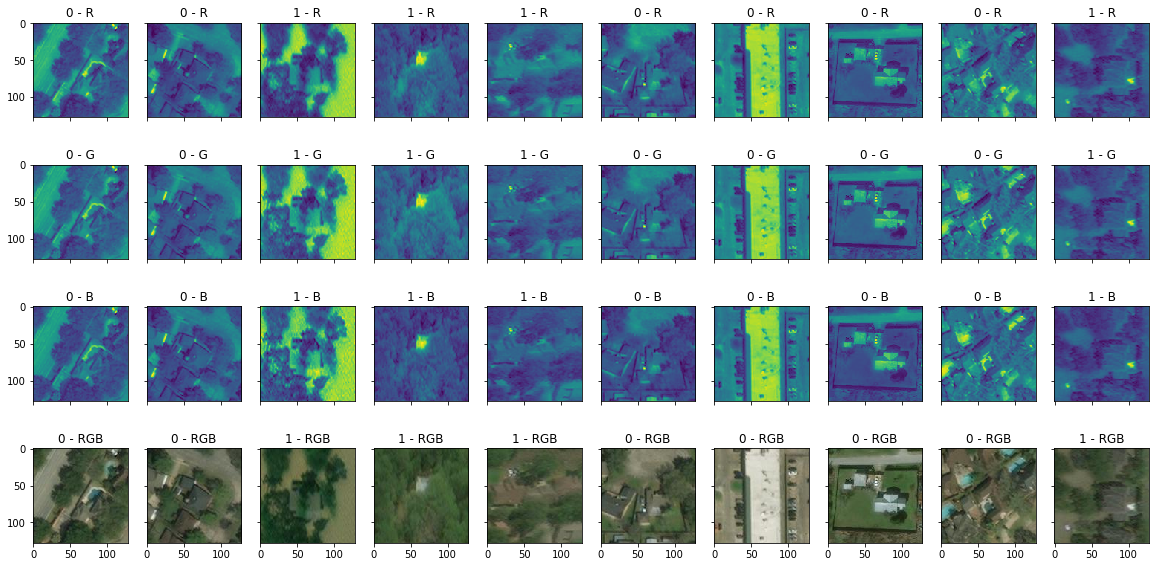

In [24]:
fig, ax = plt.subplots(nrows=4, ncols=10, sharex=True, sharey=True, figsize=(20,10))

i = 0

for image, label in train_ds.take(10):
    ax[0,i].imshow(image[:,:,0])
    ax[0,i].set_title('{} - {}'.format(label.numpy(), 'R'))
    ax[1,i].imshow(image[:,:,1])
    ax[1,i].set_title('{} - {}'.format(label.numpy(), 'G'))
    ax[2,i].imshow(image[:,:,2])
    ax[2,i].set_title('{} - {}'.format(label.numpy(), 'B'))
    ax[3,i].imshow(image)
    ax[3,i].set_title('{} - {}'.format(label.numpy(), 'RGB'))
    
    i = i+1

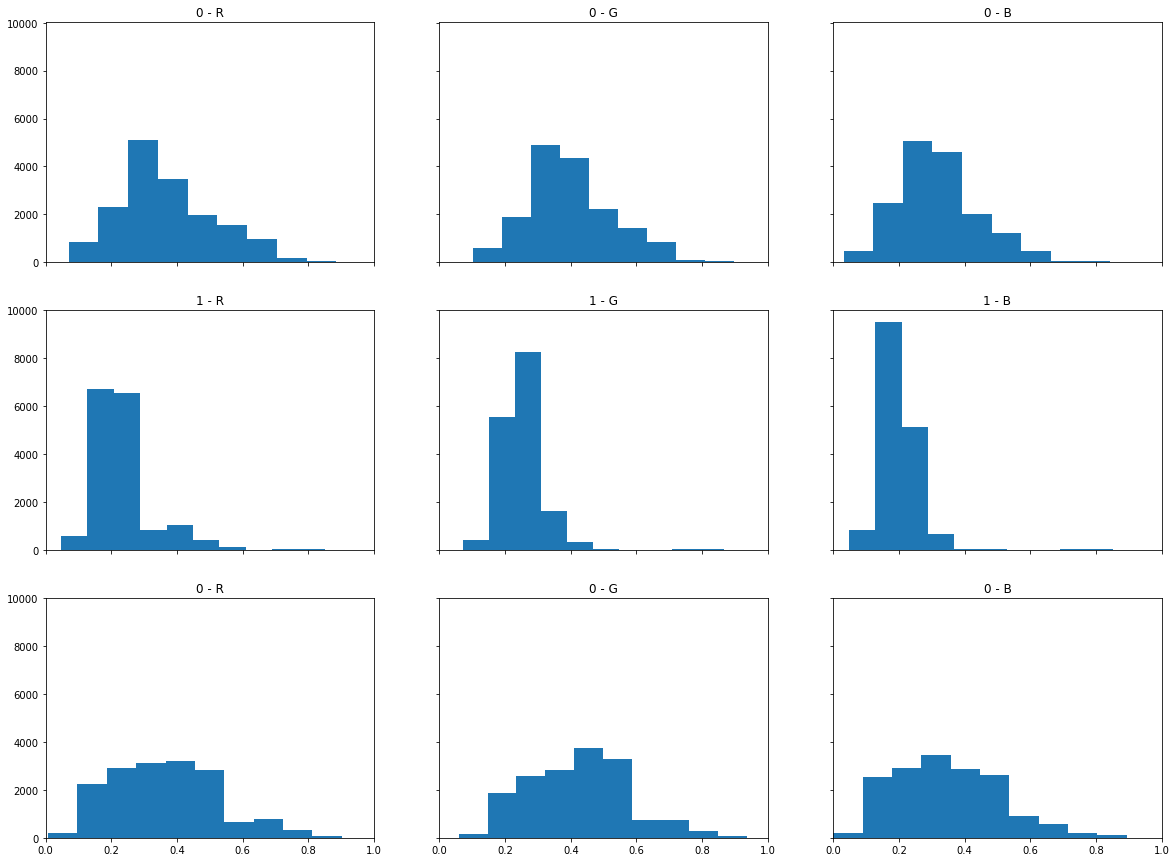

In [25]:
fig, ax = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize=(20,15))

ax[0,0].set_xlim(0,1)

i = 0

for image, label in train_ds.take(3):
    ax[i,0].hist(image[:,:,0].numpy().flatten())
    ax[i,0].set_title('{} - {}'.format(label.numpy(), 'R'))
    ax[i,1].hist(image[:,:,1].numpy().flatten())
    ax[i,1].set_title('{} - {}'.format(label.numpy(), 'G'))
    ax[i,2].hist(image[:,:,2].numpy().flatten())
    ax[i,2].set_title('{} - {}'.format(label.numpy(), 'B'))
    
    i = i+1

Batch the data. A batch size of 32 seems like a common starting point, and using powers of 2 is preferred when using a GPU.

In [26]:
BATCH_SIZE = 32

train_batches_ds = train_ds.batch(BATCH_SIZE)
val_batches_ds = val_ds.batch(BATCH_SIZE)
test_batches_ds = test_ds.batch(BATCH_SIZE)

Inspect a batch of data:

In [27]:
for image_batch, label_batch in train_batches_ds.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 128, 128, 3)
[0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 0 1 1 0 0]


# The Model

Let's use VGG16 for the base of the model:

In [28]:
IMG_SHAPE = (128, 128, 3)

# create the base model from the pre-trained model VGG16
# note that, if using a Kaggle server, internet has to be turned on
pretrained_model = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
                                                     include_top=False,
                                                     weights='imagenet')

# freeze the convolutional base
pretrained_model.trainable = False

58892288/58889256 [==============================] - 0s 0us/step


`pretrained_model` converts each 128x128x3 image to a 4x4x512 block of features. See what it does to the example batch of images:

In [29]:
feature_batch = pretrained_model(image_batch)
print(feature_batch.shape)

(32, 4, 4, 512)


Look at the model architecture:

In [30]:
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

Average over the 4x4 spatial locations to convert the block of features into a single 512-element vector per image:

In [31]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [32]:
# set the initializers with a seed for reproducible behaviour
prediction_layer = tf.keras.layers.Dense(1,
                                         kernel_initializer=tf.keras.initializers.GlorotUniform(seed=1992),
                                         bias_initializer=tf.keras.initializers.GlorotUniform(seed=1992))

prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Now stack all the components using a `tf.keras.Sequential` model:

In [33]:
model = tf.keras.Sequential([pretrained_model,
                             global_average_layer,
                             prediction_layer])

Compile the model. Since there are two classes, use a binary cross-entropy loss:

In [34]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


Train the model:

In [36]:
initial_epochs = 15
steps_per_epoch = n_train//BATCH_SIZE
validation_steps = 20

loss0, accuracy0 = model.evaluate(val_batches_ds, steps=validation_steps)

20/20 [==============================] - 4s 216ms/step - loss: 0.8649 - accuracy: 0.5016


In [37]:
history = model.fit(train_batches_ds,
                    epochs=initial_epochs,
                    validation_data=val_batches_ds,
                    validation_steps=validation_steps)

Train for 625 steps, validate for 20 steps
Epoch 1/15
625/625 [==============================] - 39s 63ms/step - loss: 0.6543 - accuracy: 0.5351 - val_loss: 0.5926 - val_accuracy: 0.5609
Epoch 2/15
625/625 [==============================] - 40s 64ms/step - loss: 0.5484 - accuracy: 0.6402 - val_loss: 0.5354 - val_accuracy: 0.7094
Epoch 3/15
625/625 [==============================] - 39s 62ms/step - loss: 0.4893 - accuracy: 0.7651 - val_loss: 0.4717 - val_accuracy: 0.7750
Epoch 4/15
625/625 [==============================] - 39s 63ms/step - loss: 0.4487 - accuracy: 0.8052 - val_loss: 0.4359 - val_accuracy: 0.8031
Epoch 5/15
625/625 [==============================] - 40s 64ms/step - loss: 0.4204 - accuracy: 0.8195 - val_loss: 0.4221 - val_accuracy: 0.7922
Epoch 6/15
625/625 [==============================] - 39s 63ms/step - loss: 0.3999 - accuracy: 0.8292 - val_loss: 0.4078 - val_accuracy: 0.8125
Epoch 7/15
625/625 [==============================] - 41s 65ms/step - loss: 0.3849 - accuracy

Learning curves:

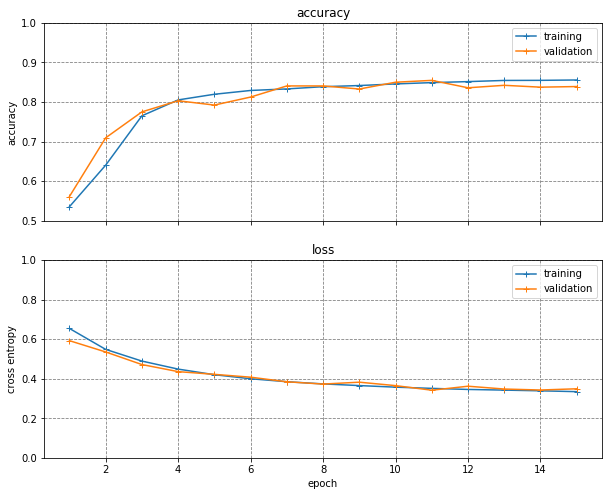

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8), sharex=True)

x_plot = np.arange(1, initial_epochs+1)

ax[0].plot(x_plot, acc, '+-', label='training')
ax[0].plot(x_plot, val_acc, '+-', label='validation')
ax[0].legend()
ax[0].set_ylabel('accuracy')
ax[0].set_ylim(0.5, 1)
ax[0].grid(ls='--', c='C7')
ax[0].set_title('accuracy')

ax[1].plot(x_plot, loss, '+-', label='training')
ax[1].plot(x_plot, val_loss, '+-', label='validation')
ax[1].legend()
ax[1].set_ylabel('cross entropy')
ax[1].set_ylim(0, 1)
ax[1].grid(ls='--', c='C7')
ax[1].set_title('loss')
ax[1].set_xlabel('epoch')

plt.show()

Some notes from the TensorFlow tutorial on transfer learning:

> Now fine-tune the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic features maps to features associated specifically to our dataset. This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned. Only a small number of top layers of the pre-trained model should be fine-tuned. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features which generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

In [39]:
# unfreeze the layers
pretrained_model.trainable = True

# let's take a look to see how many layers are in the base model
print("Number of layers in the pre-trained model: ", len(pretrained_model.layers))

Number of layers in the pre-trained model:  19


In [40]:
# fine-tune from this layer onwards
fine_tune_at = 15

# freeze all the layers before the `fine_tune_at` layer
for layer in pretrained_model.layers[:fine_tune_at]:
  layer.trainable =  False

Recompile the model using a lower training rate:

In [41]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate/75),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 7,079,937
Non-trainable params: 7,635,264
_________________________________________________________________


In [42]:
len(model.trainable_variables)

8

Continue training:

In [43]:
fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1]+1,
                         validation_data=val_batches_ds,
                         validation_steps=validation_steps)

Train for 625 steps, validate for 20 steps
Epoch 16/65
625/625 [==============================] - 41s 65ms/step - loss: 0.2821 - accuracy: 0.8762 - val_loss: 0.2528 - val_accuracy: 0.8844
Epoch 17/65
625/625 [==============================] - 41s 65ms/step - loss: 0.2261 - accuracy: 0.9024 - val_loss: 0.1913 - val_accuracy: 0.9266
Epoch 18/65
625/625 [==============================] - 40s 64ms/step - loss: 0.1966 - accuracy: 0.9161 - val_loss: 0.2203 - val_accuracy: 0.9203
Epoch 19/65
625/625 [==============================] - 40s 64ms/step - loss: 0.1785 - accuracy: 0.9230 - val_loss: 0.1973 - val_accuracy: 0.9203
Epoch 20/65
625/625 [==============================] - 40s 64ms/step - loss: 0.1620 - accuracy: 0.9311 - val_loss: 0.1624 - val_accuracy: 0.9469
Epoch 21/65
625/625 [==============================] - 39s 63ms/step - loss: 0.1522 - accuracy: 0.9353 - val_loss: 0.1701 - val_accuracy: 0.9344
Epoch 22/65
625/625 [==============================] - 40s 64ms/step - loss: 0.1379 - a

Updated training curves:

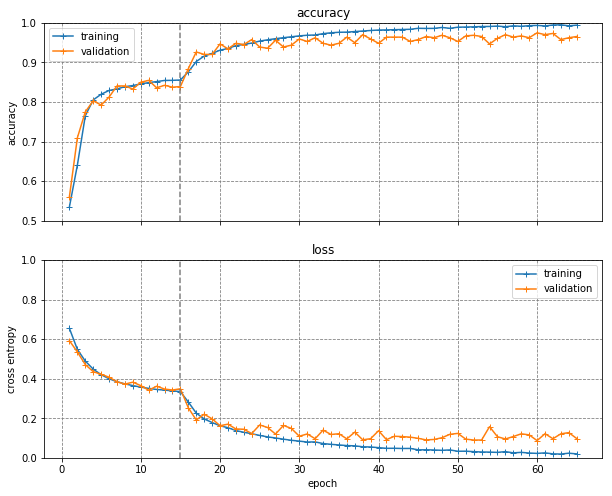

In [44]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8), sharex=True)

x_plot = np.arange(1, total_epochs+1)

ax[0].plot(x_plot, acc, '+-', label='training')
ax[0].plot(x_plot, val_acc, '+-', label='validation')
ax[0].legend()
ax[0].set_ylabel('accuracy')
ax[0].set_ylim(0.5, 1)
ax[0].grid(ls='--', c='C7')
ax[0].set_title('accuracy')
ax[0].axvline(initial_epochs, c='C7', ls='--')

ax[1].plot(x_plot, loss, '+-', label='training')
ax[1].plot(x_plot, val_loss, '+-', label='validation')
ax[1].legend()
ax[1].set_ylabel('cross entropy')
ax[1].set_ylim(0, 1)
ax[1].grid(ls='--', c='C7')
ax[1].set_title('loss')
ax[1].set_xlabel('epoch')
ax[1].axvline(initial_epochs, c='C7', ls='--')

plt.show()

Now we can evaluate the full validation and test sets:

In [45]:
val_loss, val_accuracy = model.evaluate(val_batches_ds)

125/125 [==============================] - 7s 55ms/step - loss: 0.1063 - accuracy: 0.9688


In [46]:
test_loss, test_accuracy = model.evaluate(test_batches_ds)

282/282 [==============================] - 17s 61ms/step - loss: 0.0725 - accuracy: 0.9727


Get the predictions for the test set:

In [47]:
# extract images and labels from the batches, and store predictions
eval_labels = np.array([])
eval_predictions = np.array([])
first = True
for images, labels in test_batches_ds.take(-1): #take all the batches
    if first:
        eval_images = images.numpy()
        first = False
    else:
        eval_images = np.concatenate((eval_images, images.numpy()), axis=0)
    eval_labels = np.append(eval_labels, labels.numpy())
    eval_predictions = np.append(eval_predictions, model.predict_on_batch(images).numpy())
    
# convert predictions from logit to binary
eval_predictions[eval_predictions>=0] = 1
eval_predictions[eval_predictions<0] = 0

# change dtype to int
eval_predictions = eval_predictions.astype(int)
eval_labels = eval_labels.astype(int)

# check that we extracted the images and the labels correctly
print("eval_images      : ", eval_images.shape)
print("eval_labels      : ", eval_labels.shape)
print("eval_predictions : ", eval_predictions.shape)

eval_images      :  (9000, 128, 128, 3)
eval_labels      :  (9000,)
eval_predictions :  (9000,)


Get the confusion matrix, as well as other useful metrics:

In [48]:
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(eval_labels, eval_predictions)
confusion_mtx

array([[ 952,   48],
       [ 158, 7842]])

In [49]:
from sklearn.metrics import f1_score

TN = confusion_mtx[0,0]
FN = confusion_mtx[1,0]
TP = confusion_mtx[1,1]
FP = confusion_mtx[0,1]
F1 = f1_score(eval_labels, eval_predictions)

print('accuracy = {:.4f}'.format((TP+TN)/np.sum(confusion_mtx)))
print('positive recall = {:.4f}'.format(TP/(TP+FN)))
print('negative recall = {:.4f}'.format(TN/(TN+FP)))
print('positive precision = {:.4f}'.format(TP/(TP+FP)))
print('negative precision = {:.4f}'.format(TN/(TN+FN)))

accuracy = 0.9771
positive recall = 0.9802
negative recall = 0.9520
positive precision = 0.9939
negative precision = 0.8577


Expected metrics if the test set was balanced:

In [50]:
b_TP = TP/8
b_FN = FN/8

print('accuracy = {:.4f}'.format((b_TP+TN)/np.sum(2000)))
print('positive recall = {:.4f}'.format(b_TP/(b_TP+b_FN)))
print('negative recall = {:.4f}'.format(TN/(TN+FP)))
print('positive precision = {:.4f}'.format(b_TP/(b_TP+FP)))
print('negative precision = {:.4f}'.format(TN/(TN+b_FN)))

accuracy = 0.9661
positive recall = 0.9802
negative recall = 0.9520
positive precision = 0.9533
negative precision = 0.9797


Note that it is unclear why the accuracy computed manually from the predictions is slightly different from that calculated using `model.evaluate()`... it might have to do with how batching is implemented in `model.evaluate()`.

Note that in the study associated with this dataset, the best performance achieved was:

* convolutional neural network + data augmentation + 50% dropout in the fully connected layer + Adam optimizer:
    * validation accuracy: 98.06%
    * test accuracy (balanced): 97.29%

Have a look at the images that were misclassified:

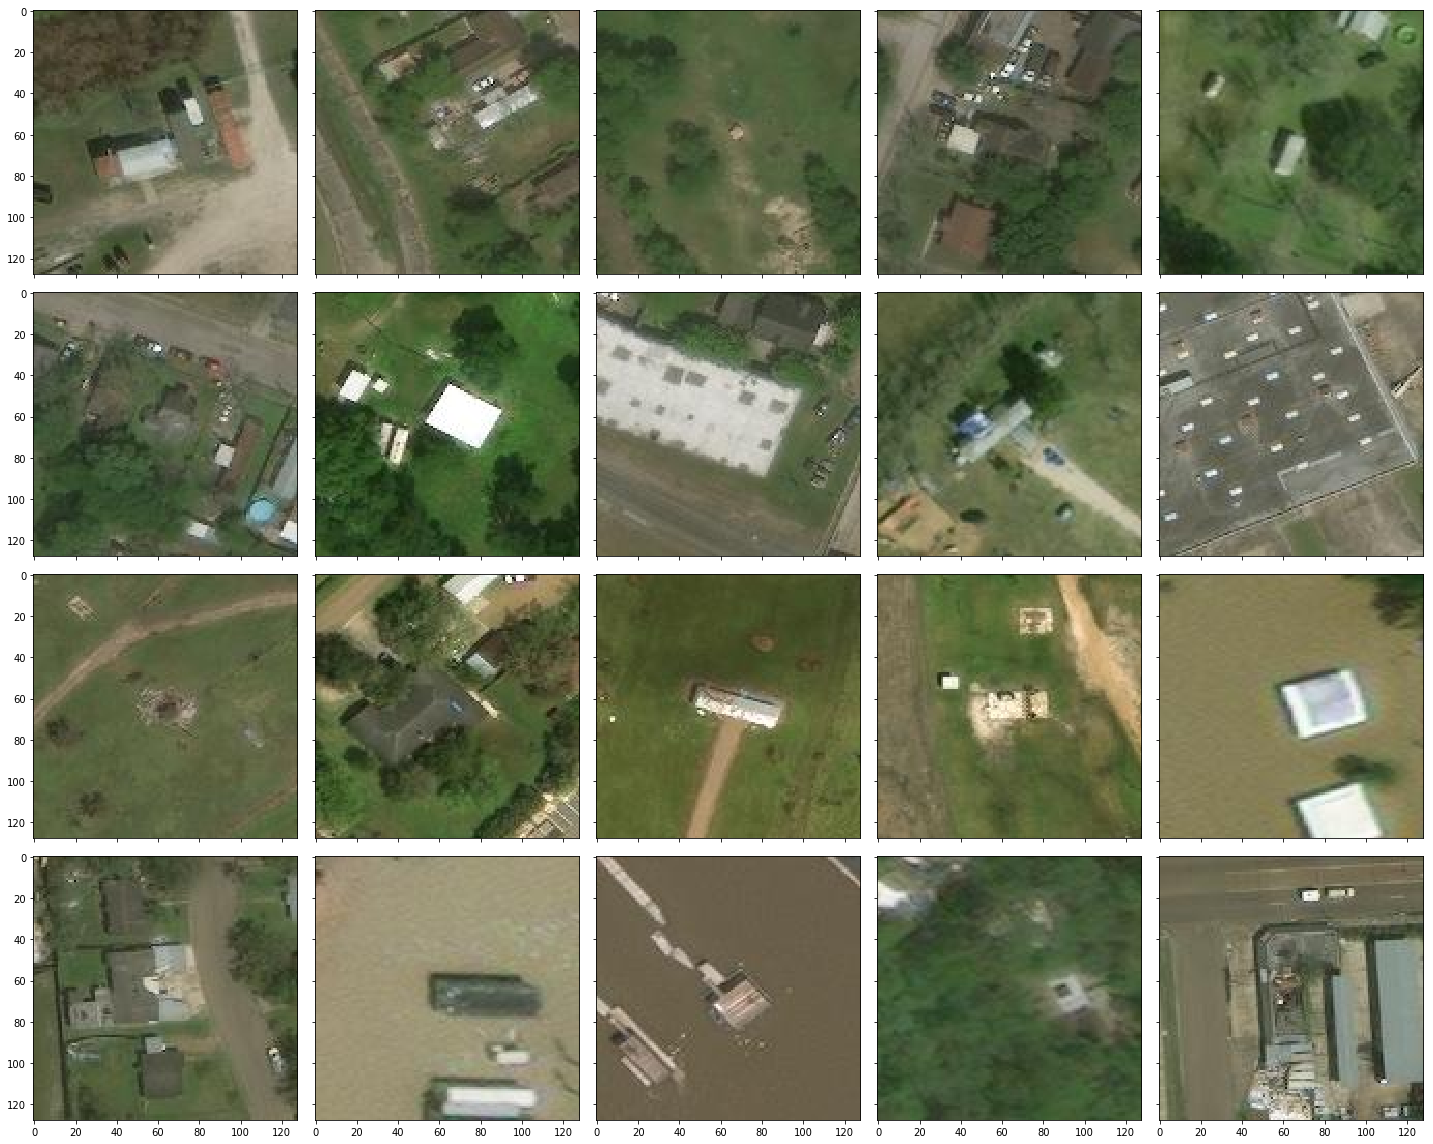

In [51]:
FP_eval_images = eval_images[(eval_labels==0)&(eval_predictions==1)]
FN_eval_images = eval_images[(eval_labels==1)&(eval_predictions==0)]

selected_FP = np.arange(10, dtype=int)*2
selected_FN = np.arange(10, dtype=int)*2

fig, ax = plt.subplots(nrows=4, ncols=5, sharex=True, sharey=True, figsize=(20,16))

ax = ax.flatten()

for i in range(10):
    ax[i].imshow(FP_eval_images[selected_FP[i]])
    
for i in range(10):
    ax[i+10].imshow(FN_eval_images[selected_FN[i]])
    
fig.tight_layout()
plt.show()